In [1]:
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
from cartopy.io.img_tiles import Stamen, GoogleTiles
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import datetime
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D as Line
from matplotlib.patheffects import Stroke
import matplotlib.ticker as mticker
import numpy as np
import shapely.geometry as sgeom
from shapely.ops import transform as geom_transform
import pandas as pd
import seaborn as sns
import sb_tools
import cmocean
import netCDF4 as nc



In [2]:
title_font = {
    'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black'}

# Load data
### Topography

In [3]:
BS_topo = nc.Dataset("C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/ARCTOScruise/BarentsSeaBathy.nc")

In [4]:
# Focus topo to interest region


lat_lim = [70, 80]
lon_lim = [5, 45]

lat_lim_index = (BS_topo.variables['lat'][:].data>lat_lim[0]) & (BS_topo.variables['lat'][:].data<lat_lim[1])
lon_lim_index = (BS_topo.variables['lon'][:].data>lon_lim[0]) & (BS_topo.variables['lon'][:].data<lon_lim[1])

lats = BS_topo.variables['lat'][:].data[lat_lim_index]
lons = BS_topo.variables['lon'][:].data[lon_lim_index]
bathy_lat = BS_topo.variables['elevation'][:].data[lat_lim_index,:]
bathy = bathy_lat[:,lon_lim_index]*-1
bathy[bathy < 0] = 1 

### Vessel transect

In [5]:
HH_2021 = pd.read_excel('E:/ARCTOScruise21/stasjonslapper_Arctos_2021.xlsx', skiprows=[1,2,3], header=0)
HH_2022 = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/PolarFront/HH_May2022/stasjonslapper_polarfront_2022.xlsx', skiprows=[1,2,3], header=0)

In [6]:
HH_2021.Latitude = [float(x[:-3])/100 for x in HH_2021.Latitude.values]
HH_2021.Longitude = [float(x[:-3])/100 for x in HH_2021.Longitude.values]

In [7]:
HH_2022.Latitude = [float(x[:-3])/100 for x in HH_2022.Latitude.values]
HH_2022.Longitude = [float(x[:-3])/100 for x in HH_2022.Longitude.values]

### Sailbuoy GPS data

In [8]:
SB_Echo22 = pd.read_excel("E:/PolarFront2022/2022-05/sailbuoy/2022_polarfront_sb_echo_1/datalogger/DATA_SBEcho2022_PF.xlsx", header=0, usecols=['Time','Lat','Long'])
SB_Iskant = pd.read_excel("E:/PolarFront2022/2022-05/sailbuoy/2022_polarfront_sb_iskant/datalogger/DATA_SBIskant2022_PF.xlsx", header=0, usecols=['Time','Lat','Long'])
SB_ADCP22 = pd.read_excel("E:/PolarFront2022/2022-05/sailbuoy/2022_polarfront_sb_adcp/datalogger/DATA_SBADCP2022_PF.xlsx", header=0, usecols=['Time','Lat','Long'])

In [9]:
SB_Iskant['Time'] = pd.to_datetime(SB_Iskant.Time)
SB_Echo22['Time'] = pd.to_datetime(SB_Echo22.Time)
SB_ADCP22['Time'] = pd.to_datetime(SB_Echo22.Time)

In [10]:
SB_Iskant21 = SB_Iskant[SB_Iskant.Time<'2022']
SB_Iskant22 = SB_Iskant[SB_Iskant.Time>'2022']

# Map 
### Sailbuoys w EK80 21/22

In [11]:
c_isk21 = sns.color_palette("colorblind")[2]
c_echo = sns.color_palette("colorblind")[4]
c_isk22 = sns.color_palette("colorblind")[3]
c_HH = 'darkred'

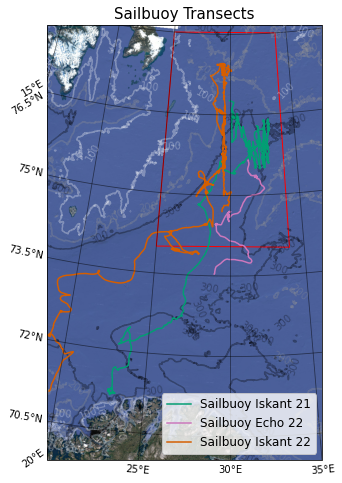

In [12]:
fig   = plt.figure(figsize=(6,8))
#ax    = plt.axes(projection = ccrs.PlateCarree())
proj = ccrs.Orthographic(central_longitude = 30, central_latitude = 75)
ax    = plt.axes(projection = proj)

# Set extent to Barents Sea
extent=[20, 35, 70, 78]
extent_zoom=[25, 34, 74, 78]
ax.set_extent(extent, crs = ccrs.PlateCarree())

cs = ax.contour(lons,lats,bathy, levels=[100, 200, 300], cmap='Greys', alpha = 0.3, transform=ccrs.PlateCarree())
plt.clabel(cs)

# Add the Stamen aerial imagery at zoom level 7.
#tiler = Stamen('terrain-background')
tiler = GoogleTiles(style = 'satellite')
ax.add_image(tiler, 8)

gl = ax.gridlines(color='k', alpha=0.5, draw_labels = True)
gl.top_labels = False
gl.right_labels = False

land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                    edgecolor='black',
                                    facecolor=cfeature.COLORS['land'])

# Add transects
plt.plot(SB_Iskant21['Long'], SB_Iskant21['Lat'], c=c_isk21, transform=ccrs.PlateCarree(), label='Sailbuoy Iskant 21')
plt.plot(SB_Echo22['Long'], SB_Echo22['Lat'], c=c_echo, transform=ccrs.PlateCarree(), label='Sailbuoy Echo 22')
plt.plot(SB_Iskant22['Long'], SB_Iskant22['Lat'],c=c_isk22, transform=ccrs.PlateCarree(), label='Sailbuoy Iskant 22')


# zoom box
extent_box = sgeom.box(extent_zoom[0], extent_zoom[2], extent_zoom[1], extent_zoom[3])
ax.add_geometries([extent_box], ccrs.PlateCarree(), facecolor='none',
                      edgecolor='red', linewidth=1)
ax.set_title('Sailbuoy Transects', title_font)
plt.legend(loc='lower right', fontsize=12)

fig.savefig('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/PolarFront/HH_May2022/SB_transects21_22.png', dpi = 300, facecolor='w', transparent=False, bbox_inches='tight')

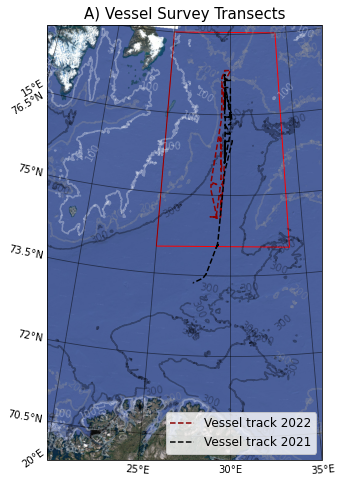

In [13]:
fig   = plt.figure(figsize=(6,8))
#ax    = plt.axes(projection = ccrs.PlateCarree())
proj = ccrs.Orthographic(central_longitude = 30, central_latitude = 75)
ax    = plt.axes(projection = proj)

# Set extent to Barents Sea
extent=[20, 35, 70, 78]
extent_zoom=[25, 34, 74, 78]
ax.set_extent(extent, crs = ccrs.PlateCarree())

cs = ax.contour(lons,lats,bathy, levels=[100, 200, 300], cmap='Greys', alpha = 0.3, transform=ccrs.PlateCarree())
plt.clabel(cs)

# Add the Stamen aerial imagery at zoom level 7.
#tiler = Stamen('terrain-background')
tiler = GoogleTiles(style = 'satellite')
ax.add_image(tiler, 8)

gl = ax.gridlines(color='k', alpha=0.5, draw_labels = True)
gl.top_labels = False
gl.right_labels = False

land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                    edgecolor='black',
                                    facecolor=cfeature.COLORS['land'])

# Add vessel transect
plt.plot(HH_2022.Longitude, HH_2022.Latitude, '--', c=c_HH, transform=ccrs.PlateCarree(), label='Vessel track 2022')
# Add vessel transect
plt.plot(HH_2021.Longitude, HH_2021.Latitude, '--', c='black', transform=ccrs.PlateCarree(), label='Vessel track 2021')


# zoom box
extent_box = sgeom.box(extent_zoom[0], extent_zoom[2], extent_zoom[1], extent_zoom[3])
ax.add_geometries([extent_box], ccrs.PlateCarree(), facecolor='none',
                      edgecolor='red', linewidth=1)
ax.set_title('A) Vessel Survey Transects', title_font)
plt.legend(loc='lower right', fontsize=12)

fig.savefig('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/PolarFront/HH_May2022/SB_transects21_22.png', dpi = 300, facecolor='w', transparent=False, bbox_inches='tight')

### Zoom time cutoff

In [14]:
Latitude_cutoff = 74
cutoff_ind21 = np.where(SB_Iskant21['Lat'] <74)[0][0]
cutoffdate_21 = SB_Iskant21.Time[cutoff_ind21]
print(f'Iskant 2021 crosses {Latitude_cutoff}N on {cutoffdate_21}')

cutoff_ind22 = np.where(SB_Iskant22['Lat'] <74)[0][0]
cutoffdate_22 = SB_Iskant22.Time.values[cutoff_ind22]
print(f'Iskant 2022 crosses {Latitude_cutoff}N on {cutoffdate_22}')

cutoff_indecho22 = np.where(SB_Echo22['Lat'] <74)[0][0]
cutoffdate_echo22 = SB_Echo22.Time[cutoff_indecho22]
print(f'Echo 2022 crosses {Latitude_cutoff}N on {cutoffdate_echo22}')

Iskant 2021 crosses 74N on 2021-07-01 23:00:00
Iskant 2022 crosses 74N on 2022-07-09T16:00:00.000000000
Echo 2022 crosses 74N on 2022-05-09 20:00:00


In [15]:
# Max lat for SB Iskant 2022
SB_Iskant22.Time.values[np.argmax(SB_Iskant22['Lat'], axis=0 )]

numpy.datetime64('2022-06-13T15:00:00.000000000')

### zoomed trajectories

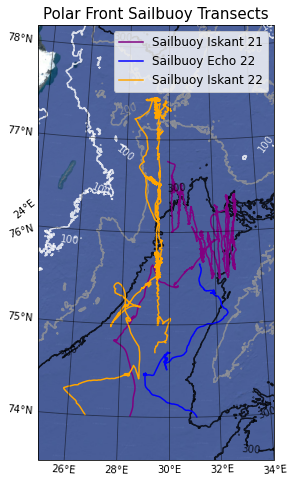

In [16]:
fig   = plt.figure(figsize=(6,8))
#ax    = plt.axes(projection = ccrs.PlateCarree())
proj = ccrs.Orthographic(central_longitude = 30, central_latitude = 75)
ax    = plt.axes(projection = proj)

# Set extent to Barents Sea
extent_zoom=[25, 34, 73.5, 78.2]
ax.set_extent(extent_zoom, crs = ccrs.PlateCarree())

cs = ax.contour(lons,lats,bathy, levels=[100, 200, 300], cmap='Greys', alpha = 0.8, transform=ccrs.PlateCarree())
plt.clabel(cs)

# Add the Stamen aerial imagery at zoom level 7.
#tiler = Stamen('terrain-background')
tiler = GoogleTiles(style = 'satellite')
ax.add_image(tiler, 8)

gl = ax.gridlines(color='k', alpha=0.5, draw_labels = True)
gl.top_labels = False
gl.right_labels = False

land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                    edgecolor='black',
                                    facecolor=cfeature.COLORS['land'])

# Add transects
plt.plot(SB_Iskant21['Long'][:cutoff_ind21], SB_Iskant21['Lat'][:cutoff_ind21], 'purple', transform=ccrs.PlateCarree(), label='Sailbuoy Iskant 21')
plt.plot(SB_Echo22['Long'][:cutoff_indecho22], SB_Echo22['Lat'][:cutoff_indecho22], 'blue', transform=ccrs.PlateCarree(), label='Sailbuoy Echo 22')
plt.plot(SB_Iskant22['Long'][:cutoff_ind22], SB_Iskant22['Lat'][:cutoff_ind22], 'orange', transform=ccrs.PlateCarree(), label='Sailbuoy Iskant 22')


ax.set_title('Polar Front Sailbuoy Transects', title_font)
plt.legend(fontsize=12)

fig.savefig('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/PolarFront/HH_May2022/SB_transects22_zoom.png', dpi = 300, facecolor='w', transparent=False, bbox_inches='tight')

# Load echo data

In [17]:
# Load mean sv
data_PF = pd.read_feather('E:/PolarFront-Exports/Svmean50.feather')

SB_Iskant21_times = SB_Iskant21.set_index(['Time']).resample('1min').interpolate()
SB_Echo22_times = SB_Echo22.set_index(['Time']).resample('1min').interpolate()
SB_Iskant22_times = SB_Iskant22.set_index(['Time']).resample('1min').interpolate()

## Combine Echo + Position for 3 platforms

In [18]:
index = []

#select iskant 21
isk_21 = data_PF[data_PF['platform']=='Sailbuoy Iskant 2021'].reset_index()
for ind in range(len(isk_21)):
    ind_index = SB_Iskant21_times.index.get_loc(isk_21.datetime[ind], method="nearest")
    index = np.append(index, ind_index)
    
#Reset index
SB_Iskant21_times = SB_Iskant21_times.reset_index()

# New df with GPS+Sv data
Isk_21_df = pd.DataFrame()
long = SB_Iskant21_times['Long'][index]
lat = SB_Iskant21_times['Lat'][index]
Isk_21_df['Time'] = isk_21.datetime
Isk_21_df['Long'] = np.array(long)
Isk_21_df['Lat'] = np.array(lat)
Isk_21_df['Sv_mean'] = isk_21.Sv_mean

In [19]:
index = []

#select echo 22
echo_22 = data_PF[data_PF['platform']=='Sailbuoy Echo 2022'].reset_index()
for ind in range(len(echo_22)):
    ind_index = SB_Echo22_times.index.get_loc(echo_22.datetime[ind], method="nearest")
    index = np.append(index, ind_index)
    
#Reset index
SB_Echo22_times = SB_Echo22_times.reset_index()

# New df with GPS+Sv data
Echo_22_df = pd.DataFrame()
long = SB_Echo22_times['Long'][index]
lat = SB_Echo22_times['Lat'][index]
Echo_22_df['Time'] = echo_22.datetime
Echo_22_df['Long'] = np.array(long)
Echo_22_df['Lat'] = np.array(lat)
Echo_22_df['Sv_mean'] = echo_22.Sv_mean

In [20]:
index = []

#select iskant 22
isk_22 = data_PF[data_PF['platform']=='Sailbuoy Iskant 2022'].reset_index()
for ind in range(len(isk_22)):
    ind_index = SB_Iskant22_times.index.get_loc(isk_22.datetime[ind], method="nearest")
    index = np.append(index, ind_index)
    
#Reset index
SB_Iskant22_times = SB_Iskant22_times.reset_index()

# New df with GPS+Sv data
Isk_22_df = pd.DataFrame()
long = SB_Iskant22_times['Long'][index]
lat = SB_Iskant22_times['Lat'][index]
Isk_22_df['Time'] = isk_22.datetime
Isk_22_df['Long'] = np.array(long)
Isk_22_df['Lat'] = np.array(lat)
Isk_22_df['Sv_mean'] = isk_22.Sv_mean

# On map

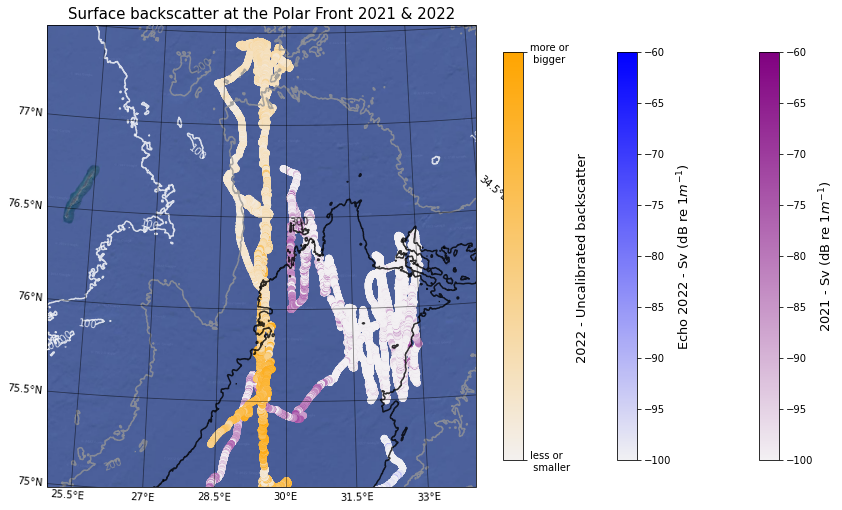

In [27]:
fig   = plt.figure(figsize=(15,15))
#ax    = plt.axes(projection = ccrs.PlateCarree())
proj = ccrs.Orthographic(central_longitude = 30, central_latitude = 75)
ax    = plt.axes(projection = proj)

# Set extent to Barents Sea
extent_zoom=[25, 34, 75, 77.5]
ax.set_extent(extent_zoom, crs = ccrs.PlateCarree())

cs = ax.contour(lons,lats,bathy, levels=[100, 200, 300], cmap='Greys', alpha = 0.8, transform=ccrs.PlateCarree())
plt.clabel(cs)

# Add the Stamen aerial imagery at zoom level 7.
#tiler = Stamen('terrain-background')
tiler = GoogleTiles(style = 'satellite')
ax.add_image(tiler, 8)

gl = ax.gridlines(color='k', alpha=0.5, draw_labels = True)
gl.top_labels = False
gl.right_labels = False

land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                    edgecolor='black',
                                    facecolor=cfeature.COLORS['land'])

# Add vessel transect
#plt.plot(HH_2022.Longitude, HH_2022.Latitude, '--', c='darkred', transform=ccrs.PlateCarree())

# Add transects
ax_0 = plt.scatter(Isk_21_df['Long'], Isk_21_df['Lat'], c=Isk_21_df['Sv_mean'], transform=ccrs.PlateCarree(), cmap=sns.color_palette("light:purple", as_cmap=True))
ax_1 = plt.scatter(Echo_22_df['Long'], Echo_22_df['Lat'], c=Echo_22_df['Sv_mean'], transform=ccrs.PlateCarree(), cmap=sns.color_palette("light:blue", as_cmap=True))
ax_2 = plt.scatter(Isk_22_df['Long'], Isk_22_df['Lat'], c=Isk_22_df['Sv_mean'], transform=ccrs.PlateCarree(), cmap=sns.color_palette("light:orange", as_cmap=True))

# Consistent cbar
ax_0.set_clim([-100,-60])
ax_1.set_clim([-100,-60])
ax_2.set_clim([-90,-50])

# add all cbar
cbar_0 = plt.colorbar(ax_0, shrink=0.5)
cbar_0.set_label('2021 - Sv (dB re $1m^{-1}$)', fontsize=13)

cbar_1 = plt.colorbar(ax_1, shrink=0.5)
cbar_1.set_label('Echo 2022 - Sv (dB re $1m^{-1}$)', fontsize=13)

cbar_2 = fig.colorbar(ax_2, shrink=0.5, ticks=[-90, -50])
cbar_2.set_label('2022 - Uncalibrated backscatter ', fontsize=13)
cbar_2.ax.set_yticklabels(['less or \n smaller', 'more or \n bigger']) 
#plt.colorbar(ax_2, shrink=0.5)

ax.set_title('Surface backscatter at the Polar Front 2021 & 2022', title_font)
#plt.legend(fontsize=12)

fig.savefig('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/PolarFront/HH_May2022/SB_Sv.png', dpi = 300, facecolor='w', transparent=False, bbox_inches='tight')

# Only 2022

In [22]:
# Add day labels
SB_Iskant22_daystamp = SB_Iskant22.set_index(['Time']).resample('7d').interpolate()

In [23]:
SB_Iskant22_daystamp = SB_Iskant22_daystamp.reset_index()

In [24]:
# date vessel
HH_2022.Date.unique()[2:]

array(['21.05.2022', '22.05.2022', '23.05.2022', '24.05.2022',
       '25.05.2022'], dtype=object)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


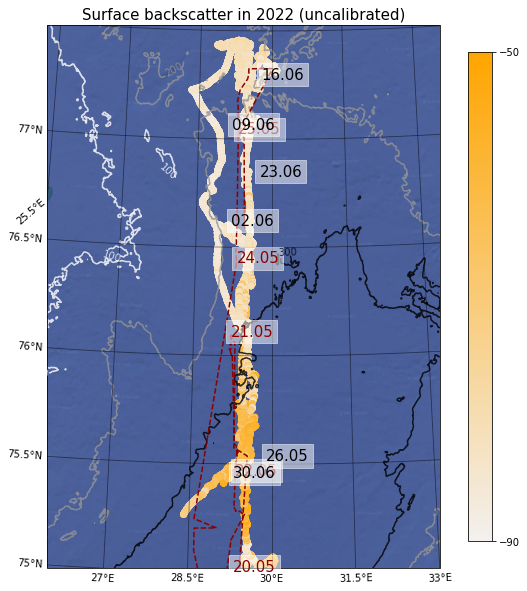

In [44]:
## Make map
fig   = plt.figure(figsize=(10,10))
#ax    = plt.axes(projection = ccrs.PlateCarree())
proj = ccrs.Orthographic(central_longitude = 30, central_latitude = 75)
ax    = plt.axes(projection = proj)

# Set extent to Barents Sea
extent_zoom=[26, 33, 75, 77.5]
ax.set_extent(extent_zoom, crs = ccrs.PlateCarree())

cs = ax.contour(lons,lats,bathy, levels=[100, 200, 300], cmap='Greys', alpha = 0.8, transform=ccrs.PlateCarree())
plt.clabel(cs)

# Add the Stamen aerial imagery at zoom level 7.
#tiler = Stamen('terrain-background')
tiler = GoogleTiles(style = 'satellite')
ax.add_image(tiler, 8)

gl = ax.gridlines(color='k', alpha=0.5, draw_labels = True)
gl.top_labels = False
gl.right_labels = False

land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                    edgecolor='black',
                                    facecolor=cfeature.COLORS['land'])


## Plot on top of map
# Add vessel transect
plt.plot(HH_2022.Longitude, HH_2022.Latitude, '--',c='darkred', transform=ccrs.PlateCarree())
for day in ['20.05.2022', '21.05.2022', '22.05.2022', '24.05.2022','25.05.2022']:
    ind = np.where(HH_2022.Date==day)[0][0]
    t = ax.text(HH_2022.Longitude[ind], HH_2022.Latitude[ind], HH_2022.Date[ind][:-5],c='darkred', weight = 85, size=15, transform=ccrs.PlateCarree())
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))

# Add transects
ax_s = plt.scatter(Isk_22_df['Long'], Isk_22_df['Lat'], c=Isk_22_df['Sv_mean'], transform=ccrs.PlateCarree(), cmap=sns.color_palette("light:orange", as_cmap=True))

for d_ind in range(len(SB_Iskant22_daystamp)-3):
    t = ax.text(SB_Iskant22_daystamp['Long'][d_ind]+0.3, SB_Iskant22_daystamp['Lat'][d_ind], SB_Iskant22_daystamp['Time'][d_ind].strftime("%d.%m"), weight = 85, size=15, transform=ccrs.PlateCarree())
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
                   
                   
# Consistent cbar
ax_s.set_clim([-90,-50])

#ax_2.set_clim([-100,-70])

# add all cbar

cbar = fig.colorbar(ax_s, shrink=0.9, ticks=[-90, -50])
cbar.set_label('Uncalibrated Volume Backscatter', fontsize=12)

#plt.colorbar(ax_2, shrink=0.5)

ax.set_title('Surface backscatter in 2022 (uncalibrated)', title_font)
#plt.legend(fontsize=12)

fig.savefig('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/PolarFront/HH_May2022/SB_Sv_22.png', dpi = 300, facecolor='w', transparent=False, bbox_inches='tight')

# Explore and compare correlations

In [40]:
Isk_21_df['platform'] = 'Sailbuoy Iskant 2021'
Echo_22_df['platform'] = 'Sailbuoy Echo 2022'
Isk_22_df['platform'] = 'Sailbuoy Iskant 2022'


PF_data = pd.concat([Isk_21_df, Echo_22_df,Isk_22_df])
# Save dataframe to use in map.
PF_data = PF_data.reset_index()

<AxesSubplot:xlabel='Lat', ylabel='Sv_mean'>

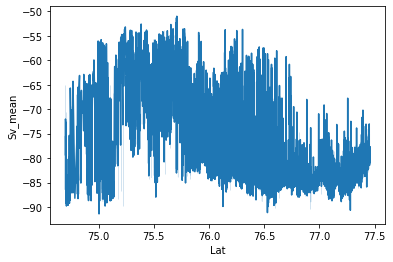

In [48]:
sns.lineplot(data=Isk_22_df,x='Lat', y='Sv_mean')

Text(24.479583333333345, 0.5, 'Sv_mean')

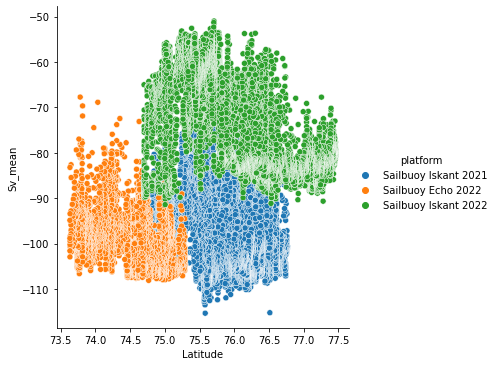

In [45]:
sns.relplot(data=PF_data, x='Lat', y='Sv_mean', hue='platform', kind='scatter')
plt.xlabel('Latitude')
plt.ylabel('Sv_mean')

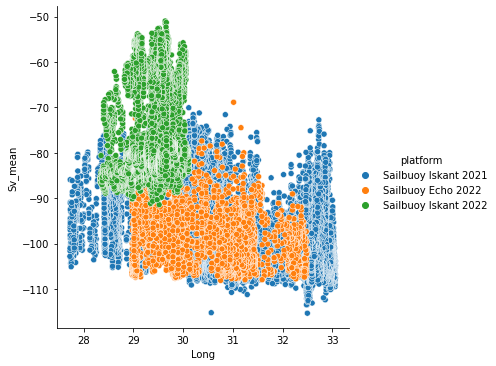

In [42]:
sns.relplot(data=PF_data, x='Long', y='Sv_mean', hue='platform', kind='scatter')


Text(22.47940972222223, 0.5, 'Sv_mean')

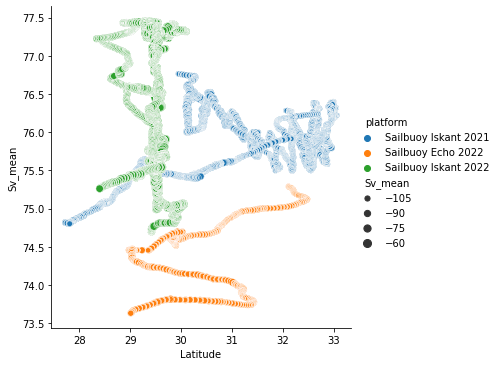

In [43]:
sns.relplot(data=PF_data, x='Long', y='Lat',size='Sv_mean', hue='platform', kind='scatter')
plt.xlabel('Latitude')
plt.ylabel('Sv_mean')